In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.stats import wasserstein_distance
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import bernoulli
from scipy.stats import nbinom

In [14]:
uniform_const = "Uniform"
soliton_const = "Soliton"
geometric_const = "Geometric"
binomial_const = "Binomial"
poisson_one_const = "Poisson(1)"
poisson_onehalf_const = "Poisson(1/2)"

poisson_with_hole_const = "Poisson with a hole in the support"
binomial_with_hole_const = "Binomial with a hole in the support"
uniform_with_hole_const = "Uniform with a hole in the support"

In [34]:
def display_wasserstein_distance_info(w_range, n_range, text="", text2="Poisson"):

    print(f"W_1({text},{text2}) is monotonically decreasing: {is_monot_decreasing(w_range)}")
    print(f"W_1({text},{text2}) is monotonically increasing: {is_monot_increasing(w_range)}")
    print()
    
    plt.figure(figsize=(10,5))
    
    plt.plot(n_range, w_range, c="black")
    plt.title(f"W_1({text},{text2})")
    plt.show()
    
def plot_pmf(x, y, title=""):
    plt.plot(x, y, 'ro')
    plt.title(title)
    plt.show()
    
def get_relative_entropy(p1, p2=[]):
    if np.size(p2) == 0:
        return scipy.stats.entropy(p1)
    
    return scipy.stats.entropy(p1, p2)

def is_monot_increasing(arr):
    return all(float(fst) <= float(snd) for fst, snd in zip(arr, arr[1:]))

def is_monot_decreasing(arr):
    return all(float(fst) >= float(snd) for fst, snd in zip(arr, arr[1:]))

In [16]:
def poi_pmf(k, k_star=5, lmb=1):
    if k == k_star:
        return 0
    elif k == k_star - 1:
        return poisson.pmf(k,lmb)+poisson.pmf(k_star,lmb)
    else:
        return poisson.pmf(k,lmb)
    
def get_poisson_pmf_array(n_max, poisson_param):
    poisson_arr = []
    
    for k in range(0,n_max):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

def get_binom_pmf_array(n, p=0):
    if p == 0:
        p = 1/n
        
    binom_arr = []
    
    for k in range(0,n):
        binom_pmf_k = binom.pmf(k, n, p)
        binom_arr.append(binom_pmf_k)
        
    return binom_arr

def pmf_of_sum(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum(n-1,i)*poi_pmf(k-i) for i in range(0, k))

def get_thinning_pmf_array(n, rv=""):
    thinning_arr = []
    
    for k in range(0,n):
        thinning_pmf_k = pmf_of_sum(n, k)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr


In [17]:
def pmf_of_sum_poi(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum_poi(n-1,i)*poi_pmf(k-i,k_star) for i in range(1, k))

def thinning_pmf(n, k, l):
    #print(n)
    
    #return sum(pmf_of_sum_poi(n,j) * binom_func(j,k,1/n) for j in range(k, k+10))
    #return sum(poisson.pmf(j,n) * binom.pmf(k,j,1/n) for j in range(k, k+300)) # does not work
    return sum(binom_func(n,j,0.5) * binom_func(j,k,1/n) for j in range(k, n+1)) # works
    #return sum(np.exp(-n)*n**j/np.math.factorial(j) * binom_func(j,k,1/n) for j in range(k, k+100))
    
    #return sum(pmf_of_sum_bin(n,j,l) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    
def get_poisson_pmf_array(K, poisson_param):
    poisson_arr = []
    
    for k in range(0,K+1):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

In [194]:
def uniform_pmf(n,k,k_star=1):
    if k > n or k < 0:
        return 0
    
    #if k < k_star:
    #    return 1/(k_star)/2
    #elif k == k_star:
    #    return 0
    #else:
    #    return 1/(n-k_star)/2
    
    if k == k_star:
        return 0
    elif k == k_star-1:
        return 2/(n+1)
    else:
        return 1/(n+1)
    
    #return 1/(n+1)
    
def benford_pmf(d):
    return np.log10(1+1/d)
    
def soliton_pmf(n, k):
    if k == 0:
        return 0
    
    if k == 1:
        return 1/n
    else:
        return 1/(k*(k-1))
    
def geom_pmf(k, k_star):
    if k == k_star:
        return 0
    elif k == k_star+1:
        return (1-p)**k * p + (1-p)**k_star * p 
    else:
        return (1-p)**k * p

def custom_dist_pmf(k,dist):
    if k >= np.size(dist) or k < 0:
        return 0

    return dist[0,k]

def binom_func(n,m,p):
    return scipy.special.binom(n,m) * (p**m) * (1-p)**(n-m)
    
def q_binom_coef(n,m,q):
    s = 1
    for i in range(0,m):
        s *= (1-q**(n-i))/(1-q**(i+1))
        
    return s

def get_binomial_pmf_array(K, p):
    bin_arr = []
    
    for k in range(0,K+1):
        bin_pmf_k = binom_func(K,k,p)#binom.pmf(k,n,p)
        bin_arr.append(bin_pmf_k)
        
    return bin_arr

def bin_pmf(n, m, p, k_star=4):
    if m == k_star: #or m == n-k_star:
        return 0
    elif m == k_star + 1:
        return binom_func(n,m,p) + binom_func(n,k_star,p) #binom.pmf(k,j,p) + binom.pmf(k_star,j,p)
    #elif m == n - k_star - 1:
    #    return binom_func(n,m,p) + binom_func(n,n-k_star,p)
    else:
        return binom_func(n,m,p)#binom.pmf(k,j,p)
    #return binom_func(n,m,p) #binom.pmf(k,j,p)

def pmf_of_sum_bin(n, l, k, k_star, dist, p=0.5):
    #print(n, l, k)
    #return binom_func(l*n,k,p)

    if n == 1:
        #return custom_dist_pmf(k,dist)
        #return geom_pmf(k,k_star)
        return bin_pmf(l,k,p,k_star)
        #return soliton_pmf(l, k)
        #return uniform_pmf(l,k)
    
    #return sum(pmf_of_sum_bin(n-1,l*n+1,i,p)*soliton_pmf(l*n+1,k-i) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(k) for i in range(0, k+1))
    
    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,dist,p)*custom_dist_pmf(k-i,dist) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*geom_pmf(k-i,k_star) for i in range(0, k+1))
    return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*bin_pmf(l,k-i,p,k_star) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(l,k-i) for i in range(0, k+1)) #uniform

def thinning_pmf(n, k, l,k_star,dist):
    #binom_func(l*n+1,j,0.5)
    #return pmf_of_sum_bin(n,l,k,k_star)
    return sum(pmf_of_sum_bin(n,l,j,k_star,dist) * binom_func(j,k,1/n) for j in range(k, l*n+1))

    #return sum(pmf_of_sum_bin(n,l,j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(nbinom.pmf(j,n,0.5) * binom_func(j,k,1/n) for j in range(k, l*n+1)) #sum of geom RV
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    

def thinning1_pmf(n, k, l,k_star,dist):
    #binom_func(l*n+1,j,0.5)
    #return pmf_of_sum_bin(n,l,k,k_star)
    return sum(pmf_of_sum_geom(n,l,j,k_star,dist) * binom_func(j,k,1/n) for j in range(k, l*n+1))

    #return sum(pmf_of_sum_bin(n,l,j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(nbinom.pmf(j,n,0.5) * binom_func(j,k,1/n) for j in range(k, l*n+1)) #sum of geom RV
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))


def pmf_of_sum_geom(n, l, k, k_star, dist, p=0.5):
    #print(n, l, k)
    #return binom_func(l*n,k,p)

    if n == 1:
        #return custom_dist_pmf(k,dist)
        return geom_pmf(k,k_star)
        #return bin_pmf(l,k,p,k_star)
        #return soliton_pmf(l, k)
        #return uniform_pmf(l,k)
    
    #return sum(pmf_of_sum_bin(n-1,l*n+1,i,p)*soliton_pmf(l*n+1,k-i) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(k) for i in range(0, k+1))
    
    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,dist,p)*custom_dist_pmf(k-i,dist) for i in range(0, k+1))
    return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*geom_pmf(k-i,k_star) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*bin_pmf(l,k-i,p,k_star) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(l,k-i) for i in range(0, k+1)) #uniform

    
def get_thinning_pmf_array(K,n,l,k_star=0,dist=[]):
    thinning_arr = []
    
    for k in range(0,K+1):
        thinning_pmf_k = thinning_pmf(n,k,l,k_star,dist)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr
   
def get_thinning1_pmf_array(K,n,l,k_star=0,dist=[]):
    thinning_arr = []
    
    for k in range(0,K+1):
        thinning_pmf_k = thinning1_pmf(n,k,l,k_star,dist)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr


In [183]:
dist1 = np.random.dirichlet(np.ones(K+1),size=1)
dist2 = np.random.dirichlet(np.ones(K+1),size=1)

exp1 = 0
exp2 = 0

for x in range(0,np.size(dist1)):
    exp1 += x*dist1[0,x]
    
for x in range(0,np.size(dist2)):
    exp2 += x*dist2[0,x]
    
print(f"E[dist1]={exp1}")
print(f"E[dist2]={exp2}")

E[dist1]=1.64050236219394
E[dist2]=1.047206738076415


p1 0.9999999999999999
n=1, pmf sum=0.96875


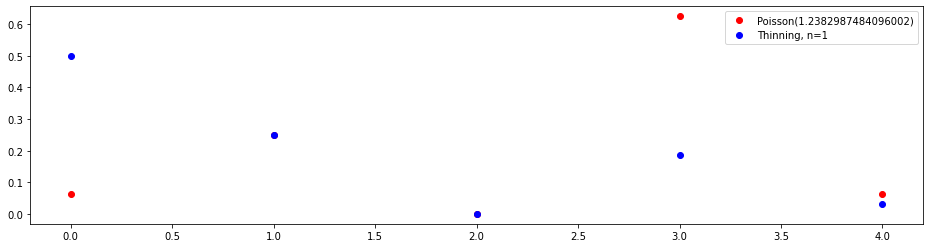

n=2, pmf sum=0.9608874320983887


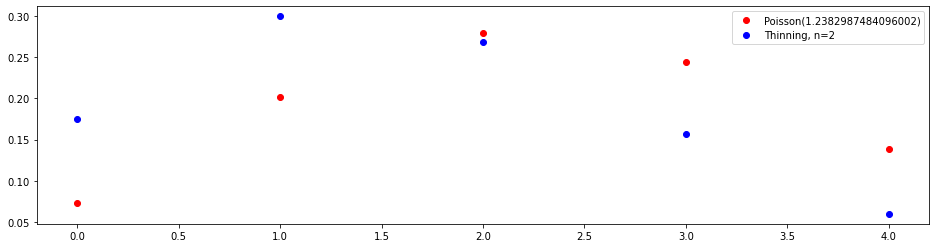

n=3, pmf sum=0.954522477574901


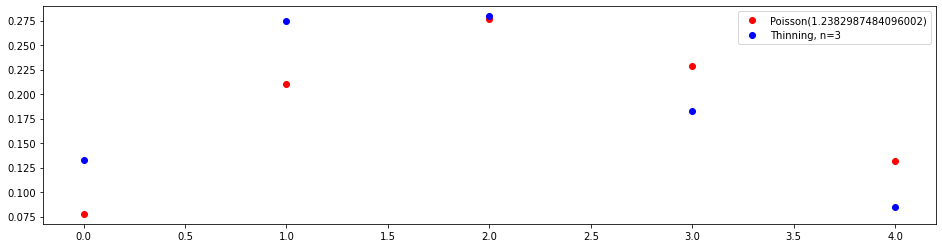

n=4, pmf sum=0.9470796264867815


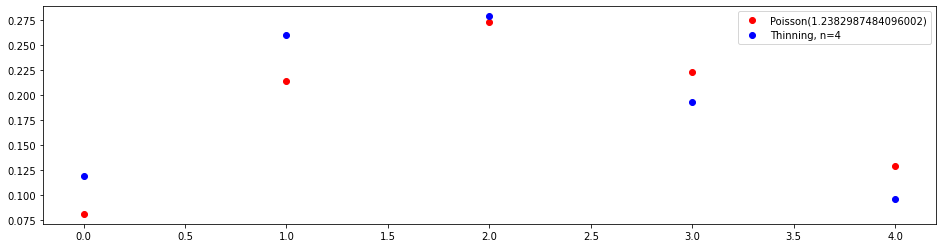

n=5, pmf sum=0.9411952645092605


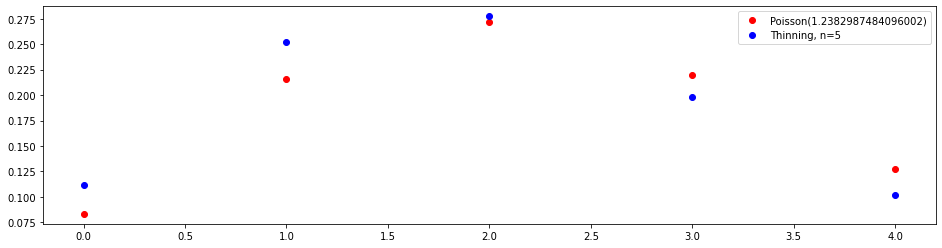

n=6, pmf sum=0.9366344931882126


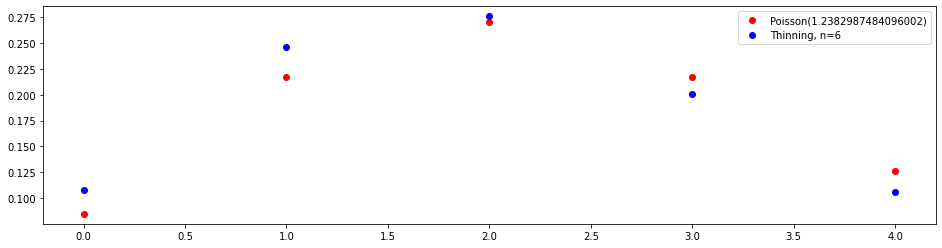

n=7, pmf sum=0.9330637228085409


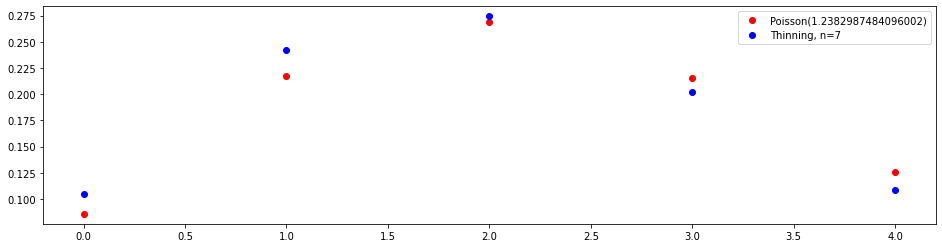

n=8, pmf sum=0.9302225439051517


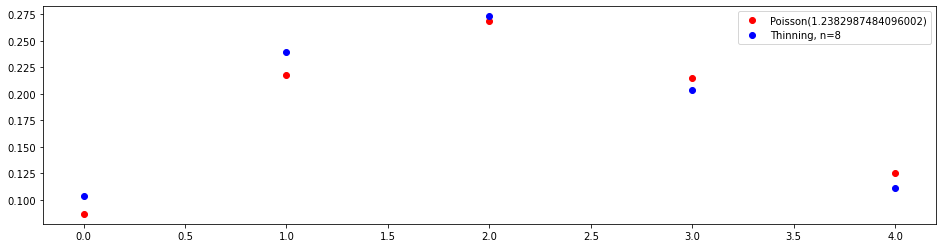

H(Binomial with a hole in the support|Poisson(1.2382987484096002)) is monotonically decreasing: True (should always be true)
[0.8496222680036711, 0.12351314897676811, 0.04121940173680556, 0.019900727635254287, 0.011583678065927281, 0.00754688646500621, 0.005297703760686431, 0.0039201302991583135]

H(Binomial with a hole in the support) is monotonically increasing: True (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.1195514398192263, 1.4991003740630473, 1.5239731443686726, 1.5312573148314785, 1.5347121237695647, 1.536729409579642, 1.5380605527403477, 1.539010698619389]

H(Binomial with a hole in the support)_8=1.539010698619389, H(Poisson(1.2382987484096002))=1.5385101031094308
H(Binomial with a hole in the support|Poisson(1.2382987484096002))=0.0039201302991583135

[0.05624999999999999, 0.020583438873291015, 0.01719298336864125, 0.017879391090706256, 0.018226444684929097, 0.01830037963759655, 0

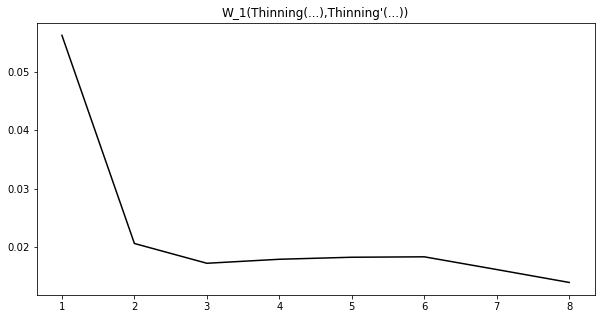

In [197]:
K = 4
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
p3 = get_binomial_pmf_array(K, p)
p1 = np.random.dirichlet(np.ones(K+1),size=1)[0] #get_poisson_pmf_array(K, lmb)
print("p1", sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

#print(dist)

n_max = 8
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 2

for n in n_range:
    #p1 = get_thinning_1_array(n, K, p)
    p1 = get_thinning_pmf_array(K, n, l, k_star, dist1)
    p2 = get_thinning1_pmf_array(K, n, l, k_star, dist2)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)", "Thinning'(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

1.4044632925692806
p1 0.985569797804419
n=1, pmf sum=1.0


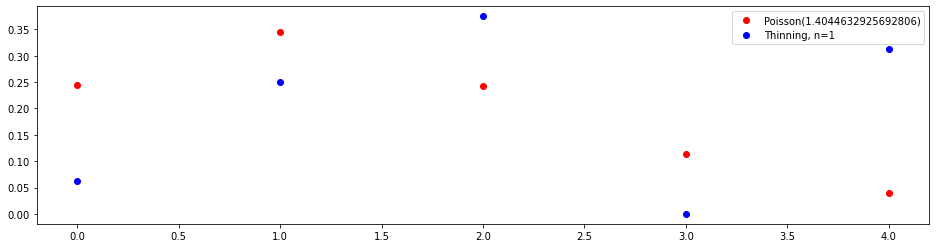

n=2, pmf sum=0.9340057373046875


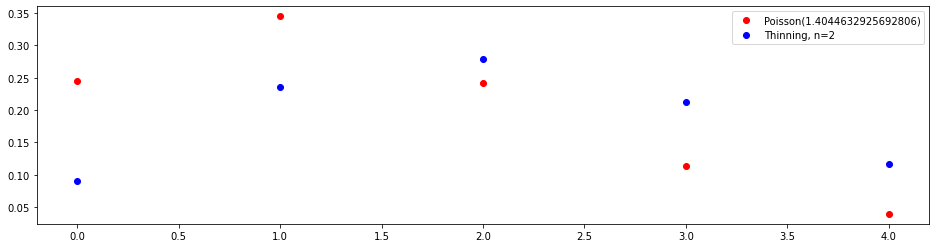

n=3, pmf sum=0.9302459582251961


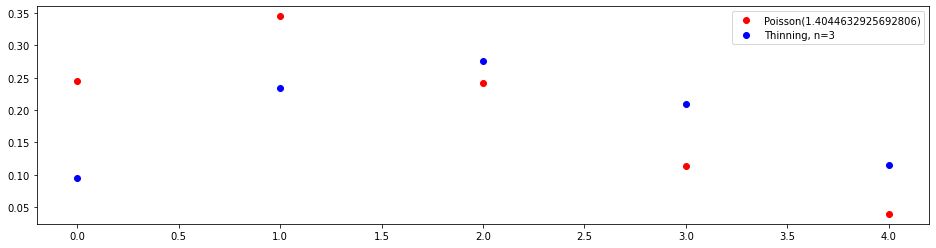

n=4, pmf sum=0.9282159629613211


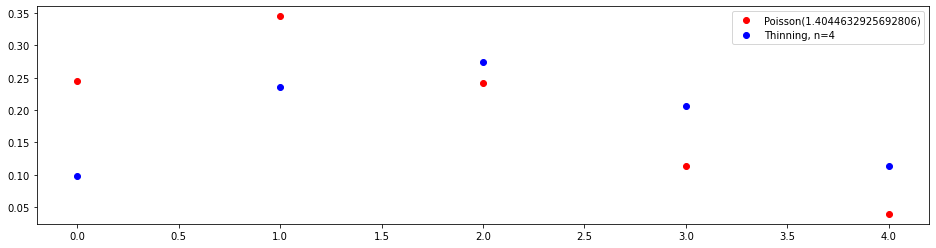

H(Binomial with a hole in the support|Poisson(1.4044632925692806)) is monotonically decreasing: True (should always be true)
[0.627619722587929, 0.18095426161391157, 0.17112460853449382, 0.16623944245695443]

H(Binomial with a hole in the support) is monotonically increasing: True (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.2511559833636317, 1.5313549988405057, 1.5358861408253024, 1.5380563850259041]

H(Binomial with a hole in the support)_4=1.5380563850259041, H(Poisson(1.4044632925692806))=1.4368548497495115
H(Binomial with a hole in the support|Poisson(1.4044632925692806))=0.16623944245695443

[0.03914672444319905, 0.03215149333023845, 0.034117173082290564, 0.03520026655389856]

W_1(Thinning(...),Poisson) is monotonically decreasing: False
W_1(Thinning(...),Poisson) is monotonically increasing: False



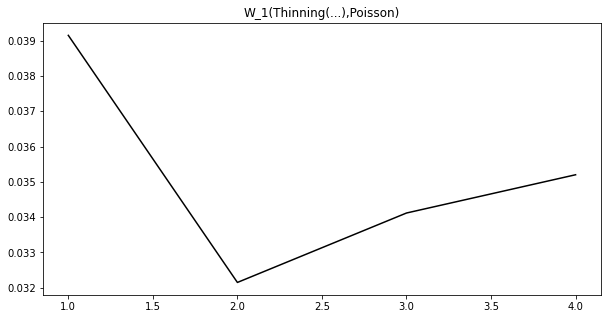

In [199]:
dist = np.random.dirichlet(np.ones(K+1),size=1)

K = 4
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
print(lmb)

p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print("p1", sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

#print(dist)

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star, dist)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

2.58672344250457
p1 1.0
n=1, pmf sum=1.0


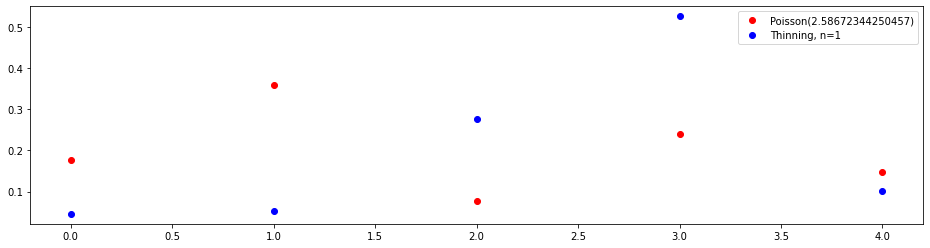

n=2, pmf sum=0.9262520588746799


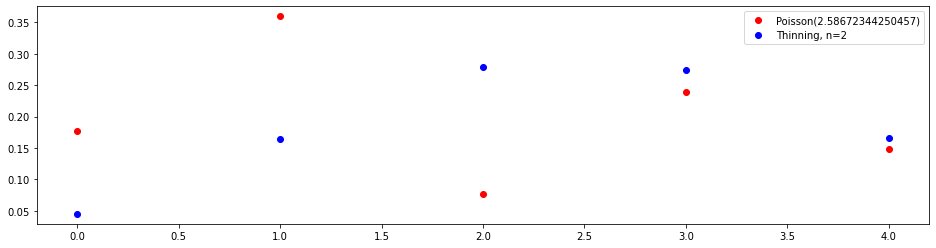

n=3, pmf sum=0.9066556961338492


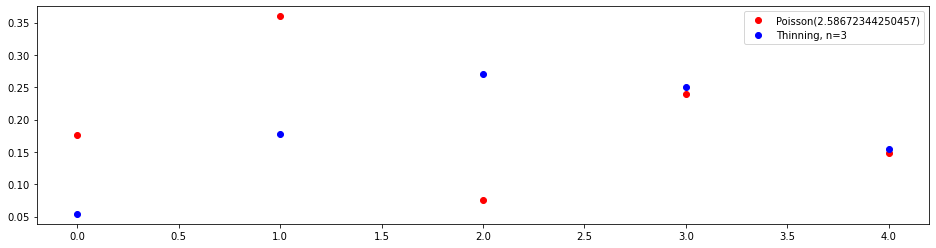

n=4, pmf sum=0.8987110964231146


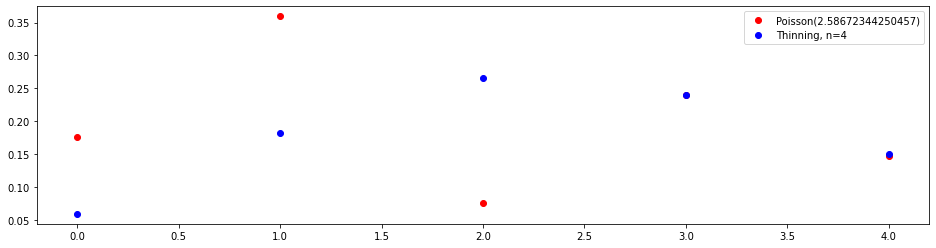

H(Binomial with a hole in the support|Poisson(2.58672344250457)) is monotonically decreasing: True (should always be true)
[0.5669667601308969, 0.3193523675808462, 0.28598035467559363, 0.27050008199453557]

H(Binomial with a hole in the support) is monotonically increasing: True (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.2190369579965887, 1.482720442648913, 1.5053941059092597, 1.5154301281894758]

H(Binomial with a hole in the support)_4=1.5154301281894758, H(Poisson(2.58672344250457))=1.4950977879282004
H(Binomial with a hole in the support|Poisson(2.58672344250457))=0.27050008199453557

[0.08071825268107949, 0.0347837930143134, 0.026009223414265533, 0.024190269438529546]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



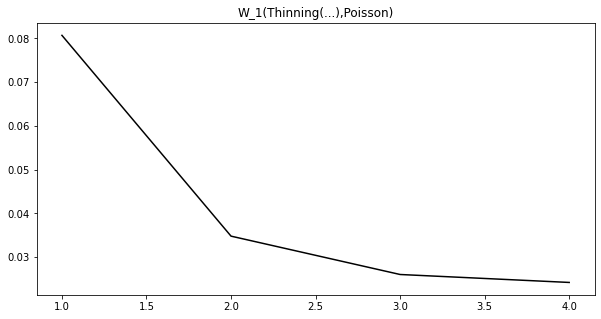

In [121]:
dist = np.random.dirichlet(np.ones(K+1),size=1)

K = 4
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
print(lmb)

p3 = get_binomial_pmf_array(K, p)
p1 = np.random.dirichlet(np.ones(K+1),size=1)[0] #get_poisson_pmf_array(K, lmb)
print("p1", sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

#print(dist)

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Geometric distribution with a hole in the support -> Poisson distribution

0.9999998885745216
n=1, pmf sum=0.9990234375


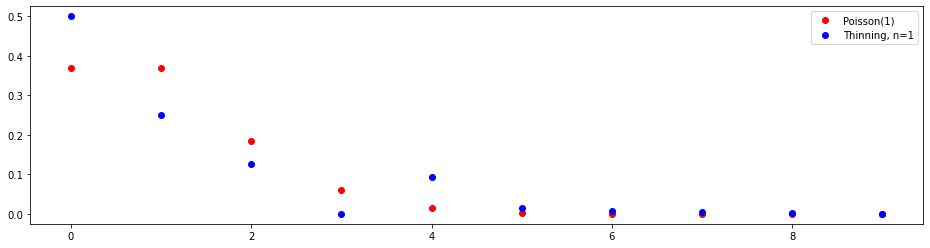

n=2, pmf sum=0.9998441288407776


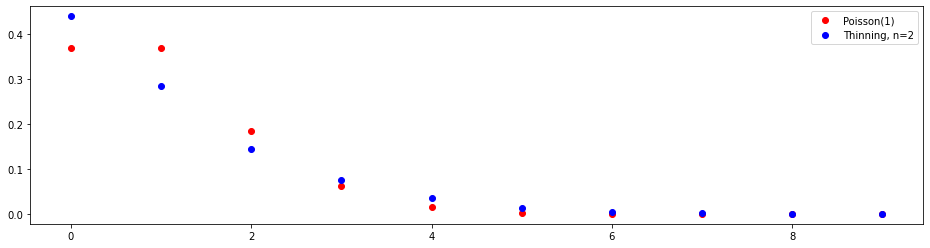

n=3, pmf sum=0.9999527984405061


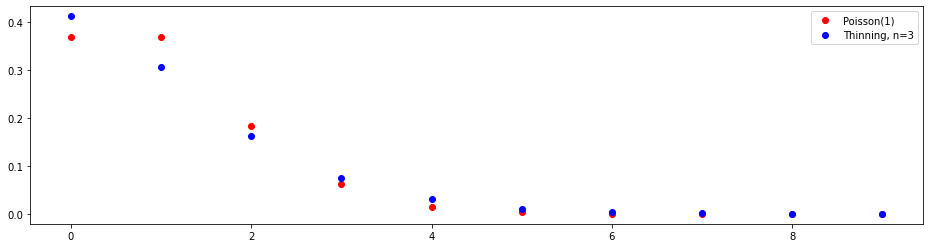

n=4, pmf sum=0.9999783691336437


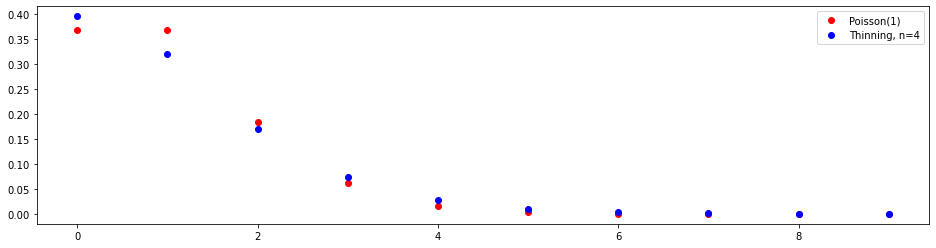

n=5, pmf sum=0.9999877381122756


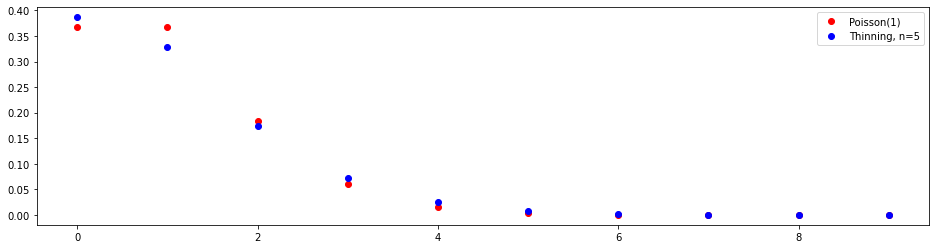

H(Binomial with a hole in the support|Poisson(1)) is monotonically decreasing: True (should always be true)
[0.259060274920051, 0.058114190937741755, 0.03012317137690311, 0.0188630122891223, 0.013223030558907948]

H(Binomial with a hole in the support) is monotonically increasing: False (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.3188101543538808, 1.4166451418239858, 1.4031525209823508, 1.3924591937913522, 1.3845906461372162]

H(Binomial with a hole in the support)_5=1.3845906461372162, H(Poisson(1))=1.3048404554454895
H(Binomial with a hole in the support|Poisson(1))=0.013223030558907948

[0.03526638999940446, 0.024675695235493764, 0.01686418173437207, 0.012552500512417773, 0.009839623391144109]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



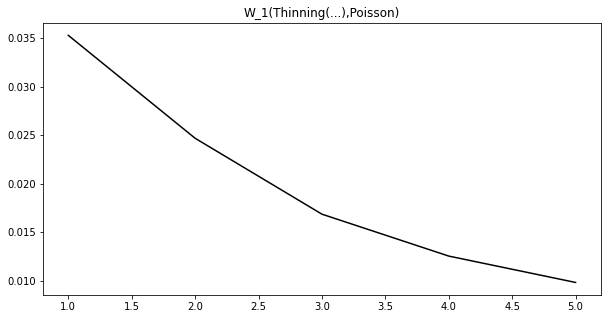

In [47]:
from decimal import Decimal

K = 9
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = (1-p)/p
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution with a hole in the support -> Poisson distribution

0.9829072671006216
n=1, pmf sum=1.0


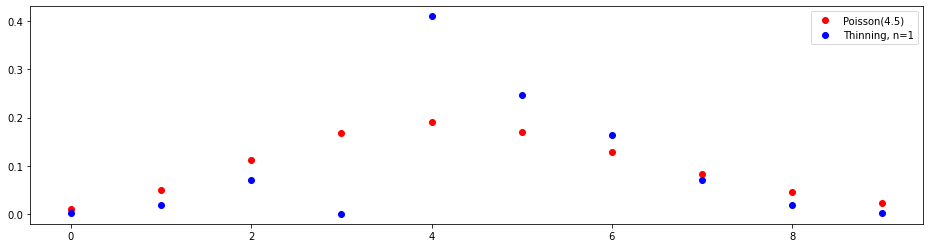

n=2, pmf sum=0.9943183370924089


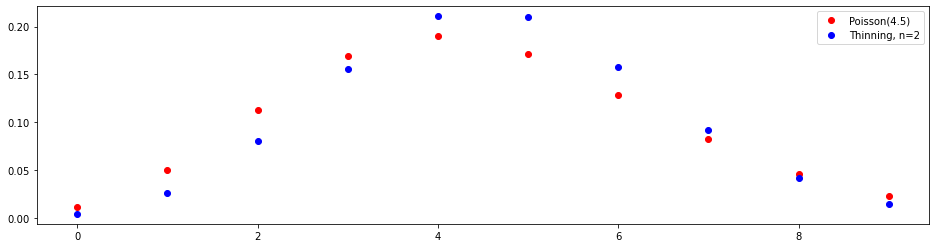

n=3, pmf sum=0.9898639599934049


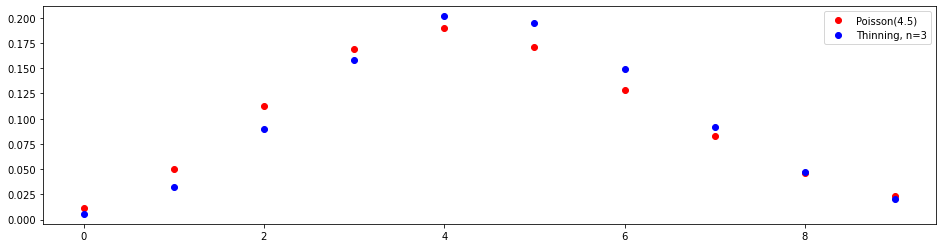

n=4, pmf sum=0.9872620110775043


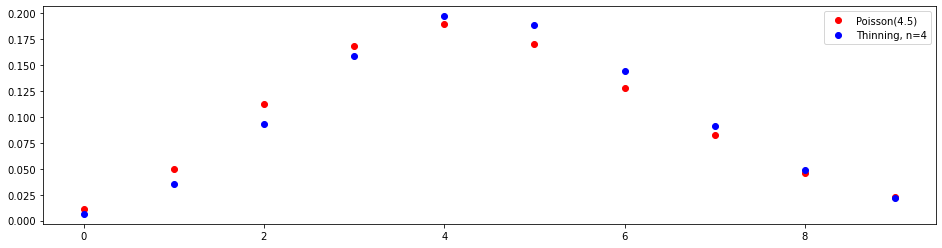

H(Binomial with a hole in the support|Poisson(4.5)) is monotonically decreasing: True (should always be true)
[0.34141538709323715, 0.025801400233776185, 0.012558668083437951, 0.008431743676203968]

H(Binomial with a hole in the support) is monotonically increasing: True (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.5468868930272324, 1.9799187144987875, 2.024311710125651, 2.042498868444099]

H(Binomial with a hole in the support)_4=2.042498868444099, H(Poisson(4.5))=2.0800787768255935
H(Binomial with a hole in the support|Poisson(4.5))=0.008431743676203968

[0.05741383090481483, 0.016382994756641157, 0.011985546997627163, 0.009835198955036642]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



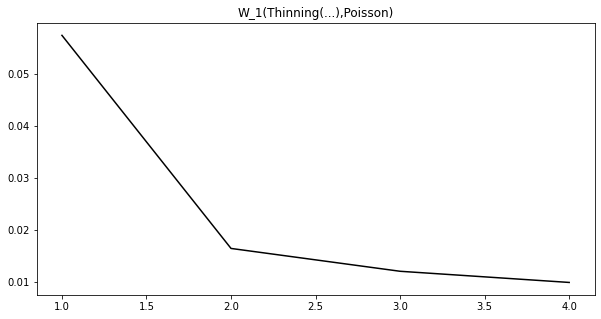

In [24]:
from decimal import Decimal

K = 9
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = l*p
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform distribution with a hole in the support -> Poisson distribution

0.9863047314016166
n=1, pmf sum=1.0000000000000002


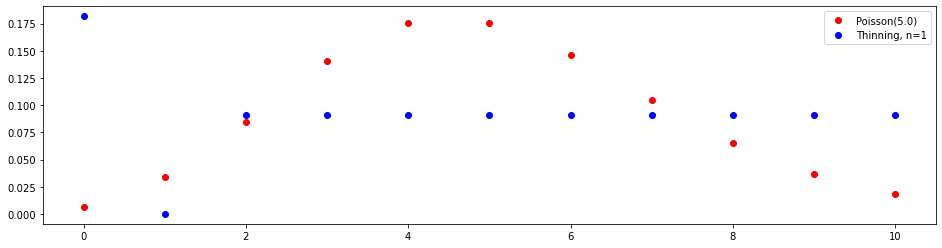

n=2, pmf sum=0.9698433521365333


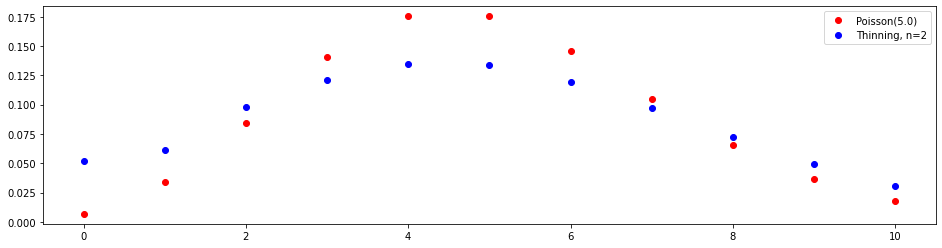

n=3, pmf sum=0.9745980140029978


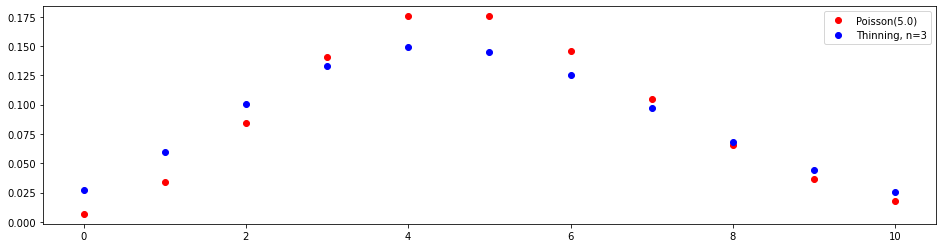

n=4, pmf sum=0.9773847097965442


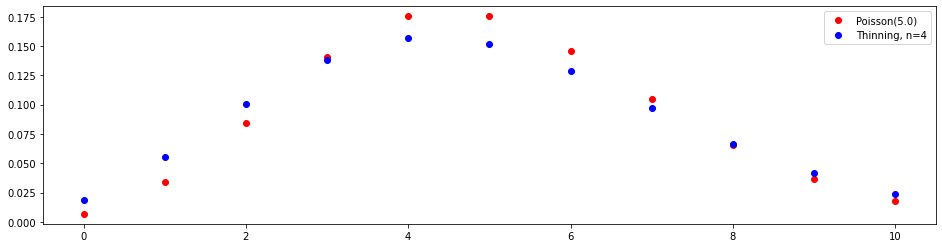

n=5, pmf sum=0.979204023617008


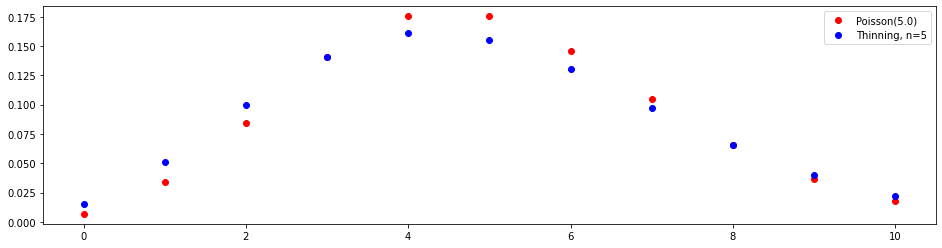

H(Uniform with a hole in the support|Poisson(5.0)) is monotonically decreasing: True (should always be true)
[0.637619798887781, 0.09408176713961403, 0.03702580236448971, 0.02016541022135677, 0.012959333626266823]

H(Uniform with a hole in the support) is monotonically increasing: False (should be true only in ULC case)
H(Uniform with a hole in the support) is monotonically decreasing: False (should be true only in ULConvex case)
[2.2718685126965625, 2.3128675753663037, 2.2626707321604766, 2.233314141439605, 2.2150921578737144]

H(Uniform with a hole in the support)_5=2.2150921578737144, H(Poisson(5.0))=2.146692802738898
H(Uniform with a hole in the support|Poisson(5.0))=0.012959333626266823

[0.03935602806199528, 0.023056360314261087, 0.015188005516352408, 0.011372490269652698, 0.009194404567209142]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



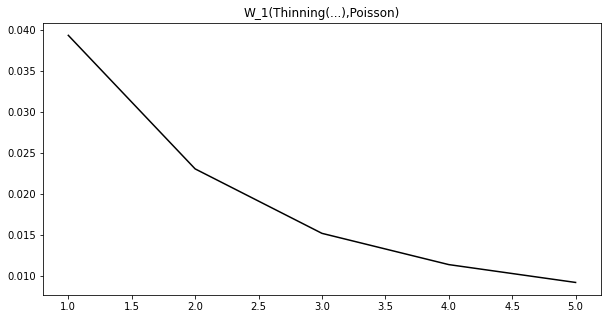

In [145]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = K/2
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = uniform_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform distribution with a hole in the support vs Binomial distribution

1.0
n=1, pmf sum=1.0000000000000002


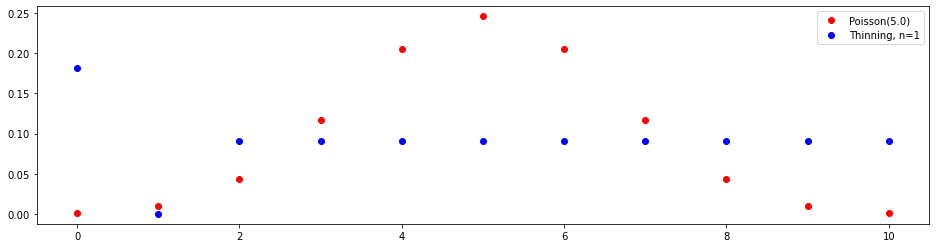

n=2, pmf sum=0.9698433521365333


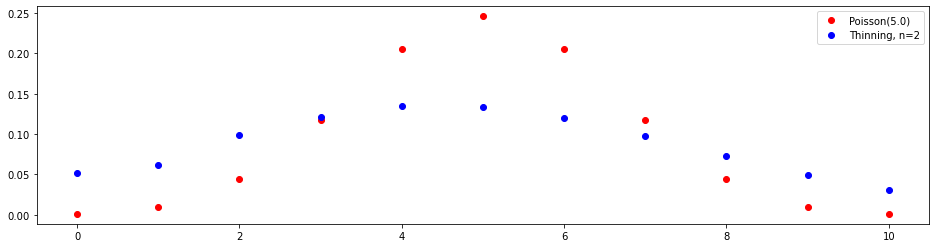

n=3, pmf sum=0.9745980140029978


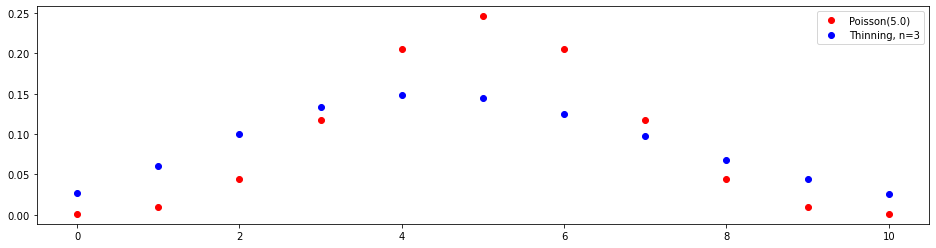

n=4, pmf sum=0.9773847097965442


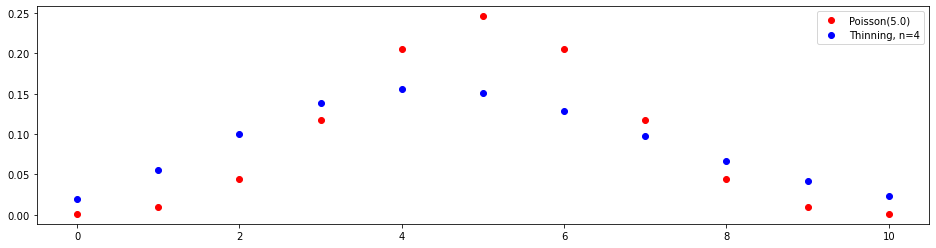

n=5, pmf sum=0.979204023617008


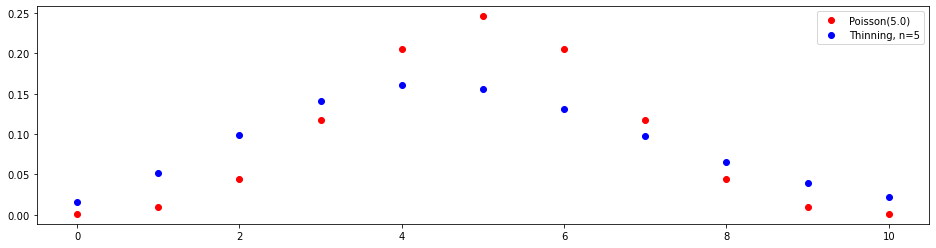

H(Uniform with a hole in the support|Poisson(5.0)) is monotonically decreasing: True (should always be true)
[1.4128271377169694, 0.44426164986612016, 0.30697260203837756, 0.25275766348593115, 0.22381572051796228]

H(Uniform with a hole in the support) is monotonically increasing: False (should be true only in ULC case)
H(Uniform with a hole in the support) is monotonically decreasing: False (should be true only in ULConvex case)
[2.2718685126965625, 2.3128675753663037, 2.2626707321604766, 2.233314141439605, 2.2150921578737144]

H(Uniform with a hole in the support)_5=2.2150921578737144, H(Poisson(5.0))=1.8759536052468004
H(Uniform with a hole in the support|Poisson(5.0))=0.22381572051796228

[0.06293582128099173, 0.04928887795004784, 0.04241664854368644, 0.039200467521834356, 0.03743146538700205]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



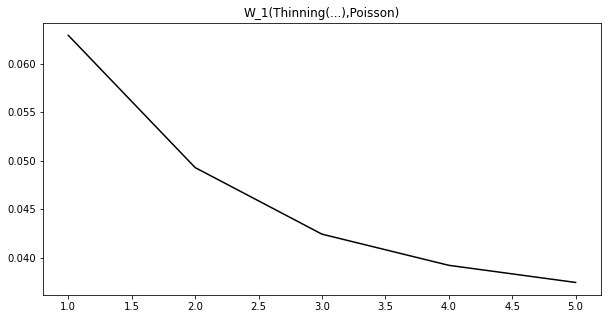

In [144]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = K/2
p1 = get_binomial_pmf_array(K, p)
p3 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = uniform_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution with a hole in the support vs Binomial distribution

1.0
n=1, pmf sum=1.0


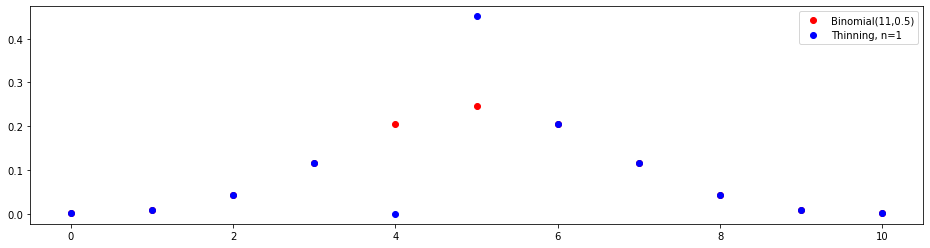

n=2, pmf sum=0.9956603343543975


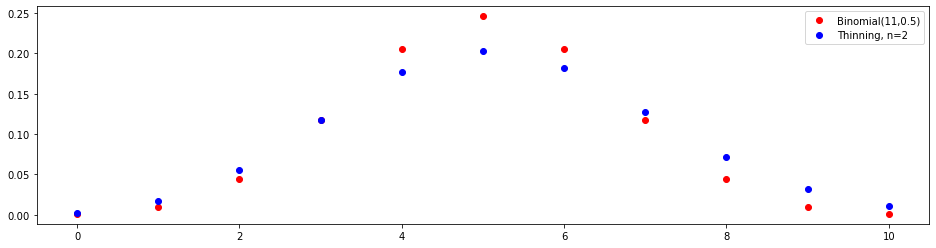

n=3, pmf sum=0.9917483478483934


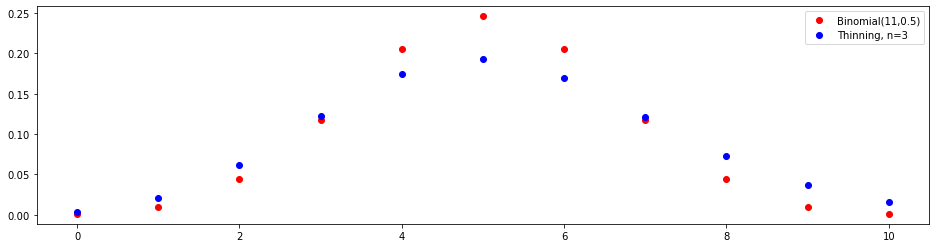

n=4, pmf sum=0.9894868587988979


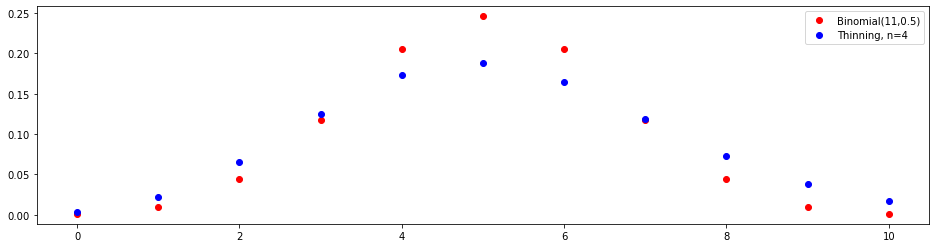

H(Binomial with a hole in the support|Binomial(11,0.5)) is monotonically decreasing: False
[0.27347142700145094, 0.05233240598410757, 0.08051801548408677, 0.09460665363516776]

H(Binomial with a hole in the support) is monotonically increasing: True (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.5650920152309642, 2.050795492032602, 2.0929372766116194, 2.110557944458539]

H(Binomial with a hole in the support)_4=2.110557944458539, H(Binomial(11,0.5))=1.8759536052468004
H(Binomial with a hole in the support|Binomial(11,0.5))=0.09460665363516776

[0.03728693181818182, 0.01673176093490011, 0.020967188951341035, 0.02286380724883915]

W_1(Thinning(...),Binomial(11,0.5)) is monotonically decreasing: False
W_1(Thinning(...),Binomial(11,0.5)) is monotonically increasing: False



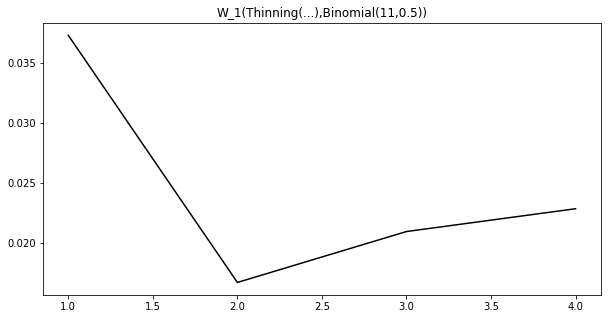

In [40]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 5
p1 = get_binomial_pmf_array(K, p)
p3 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 4

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Binomial({l+1},{p})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Binomial({l+1},{p})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)}")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Binomial({l+1},{p}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Binomial({l+1},{p}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)", f'Binomial({l+1},{p})')

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Geometric distribution -> Poisson distribution

0.9999999899522336
n=1, pmf sum=0.9995117187499999


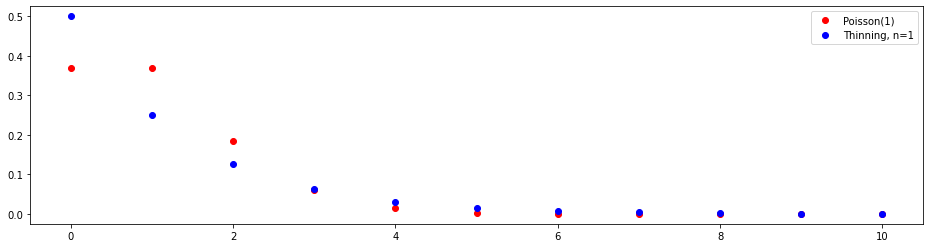

n=11, pmf sum=0.9999997850760606


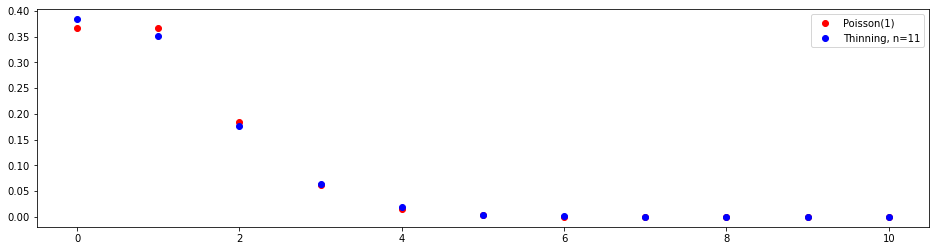

n=21, pmf sum=0.9999999379770498


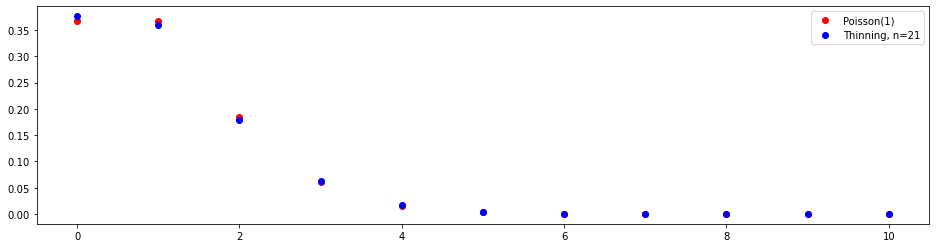

n=31, pmf sum=0.9999999632309221


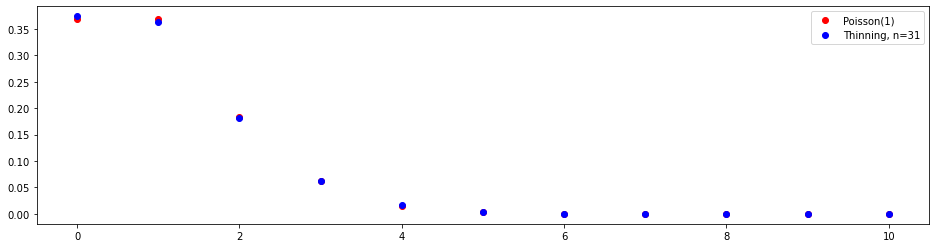

n=41, pmf sum=0.9999999724588988


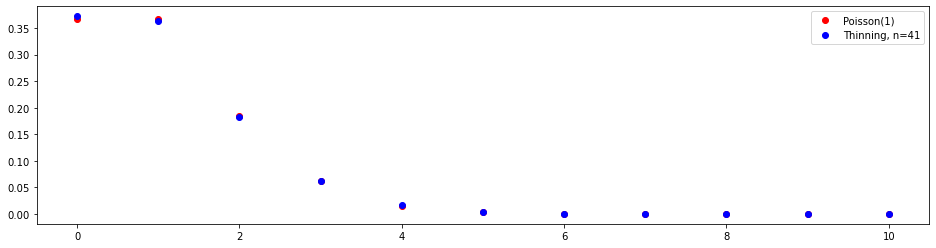

n=51, pmf sum=0.9999999770767787


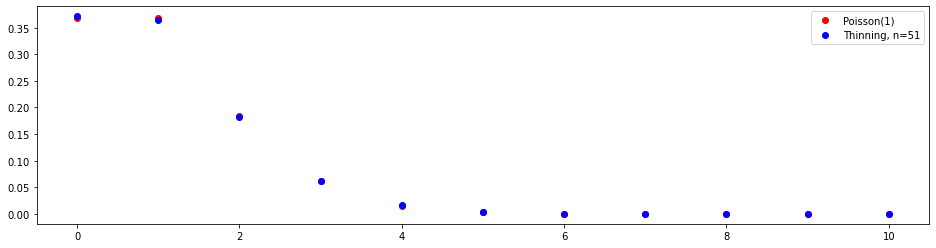

n=61, pmf sum=0.9999999798096295


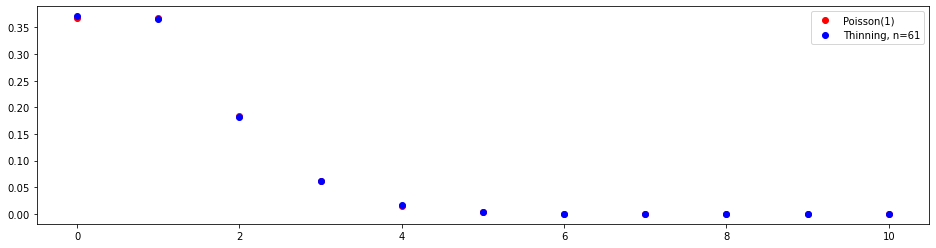

n=71, pmf sum=0.9999999816036257


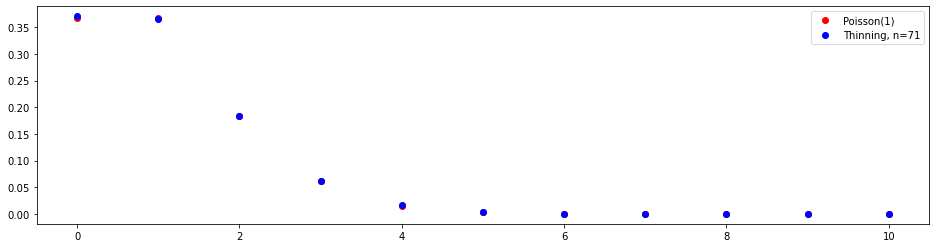

n=81, pmf sum=0.9999999828669054


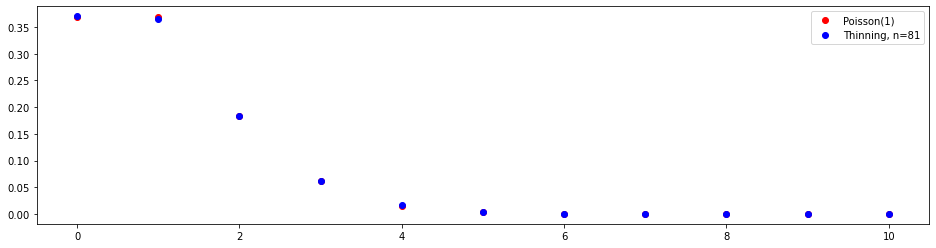

n=91, pmf sum=0.9999999838025709


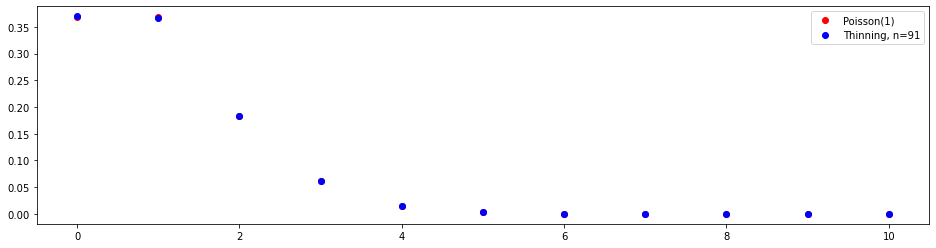

H(Geometric|Poisson(1)) is monotonically decreasing: True (should always be true)
[0.11620012586532968, 0.0018932961664297884, 0.0005410555949533268, 0.0002519937086051594, 0.00014516934933584338, 9.426229482330116e-05, 6.609857366865238e-05, 4.890172265210023e-05, 3.763718423499626e-05, 2.9859843036026974e-05]

H(Geometric) is monotonically increasing: False (should be true only in ULC case)
H(Geometric) is monotonically decreasing: True (should be true only in ULConvex case)
[1.3820811833935656, 1.3241431494590903, 1.3154903631728638, 1.312191272257523, 1.310452446090547, 1.30937888246685, 1.3086501433858446, 1.30812309683822, 1.3077241934900388, 1.3074117671530154]

H(Geometric)_100=1.3074117671530154, H(Poisson(1))=1.304842057169971
H(Geometric|Poisson(1))=2.9859843036026974e-05

[0.03210455021019028, 0.0043319304177948485, 0.0023244334774841545, 0.0015884026385513323, 0.0012064045005622445, 0.0009725229029056276, 0.0008145999642243143, 0.0007008008957491954, 0.0006148999503496066,

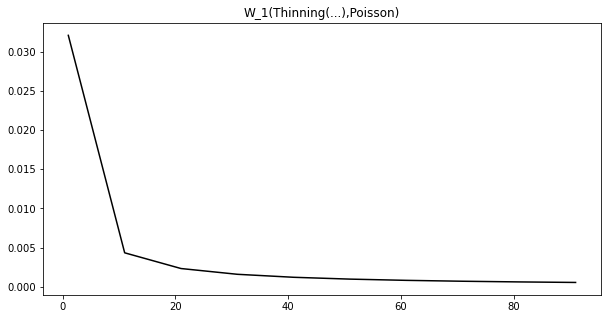

In [21]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
lmb = 1
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 100
n_step = 10
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
thinning_rv = geometric_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution -> Poisson distribution

0.9863047314016166
n=1, pmf sum=1.0


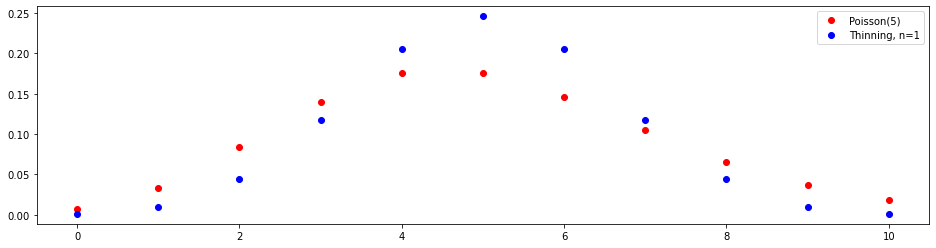

n=11, pmf sum=0.988329443631719


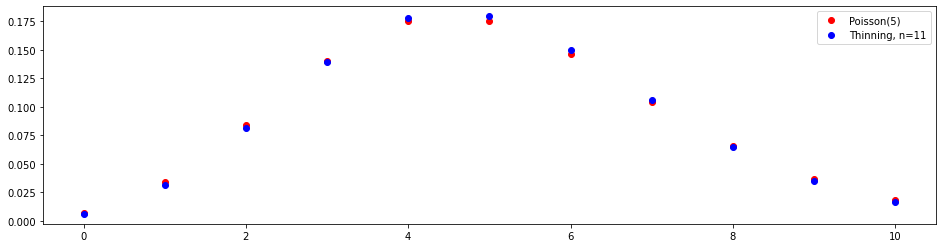

n=21, pmf sum=0.9873746384936806


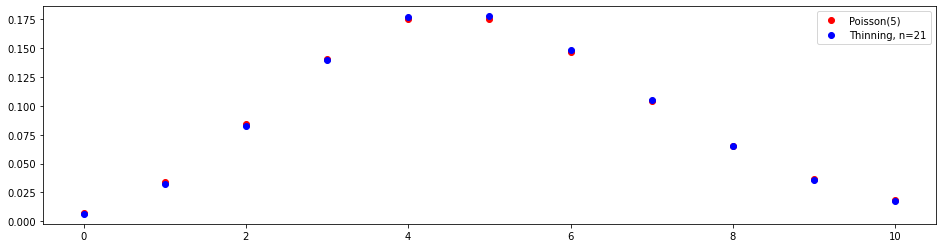

n=31, pmf sum=0.9870316314906742


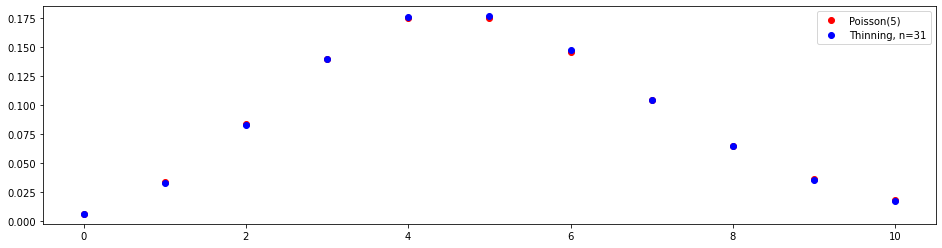

n=41, pmf sum=0.9868551432798108


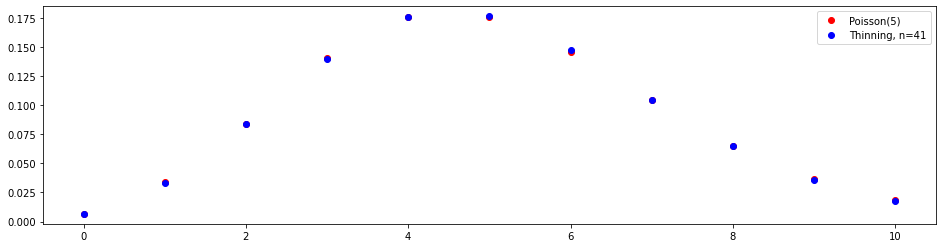

n=51, pmf sum=0.986747607715943


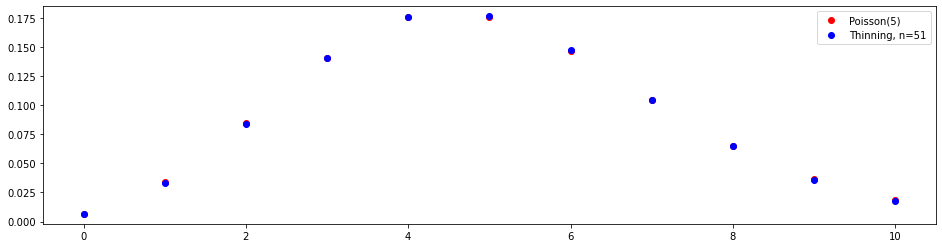

n=61, pmf sum=0.9866752215732334


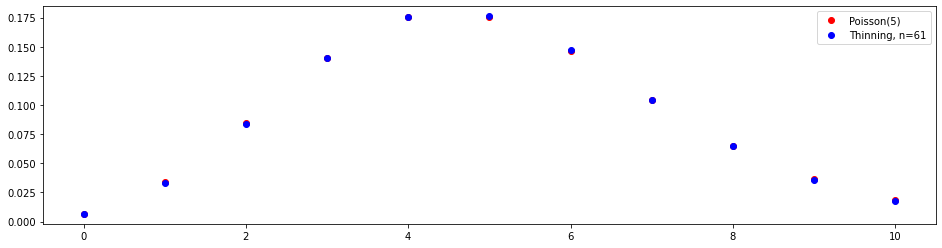

n=71, pmf sum=0.986623172770854


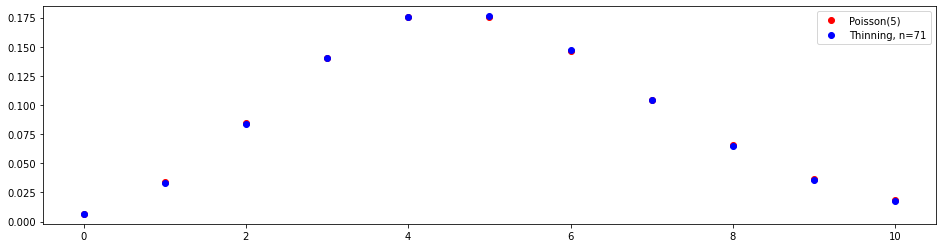

n=81, pmf sum=0.9865839464135951


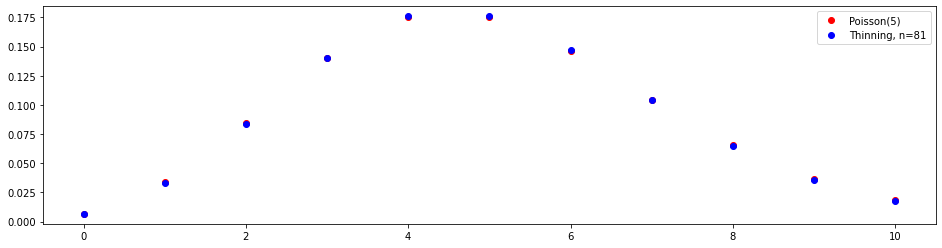

n=91, pmf sum=0.986553323951523


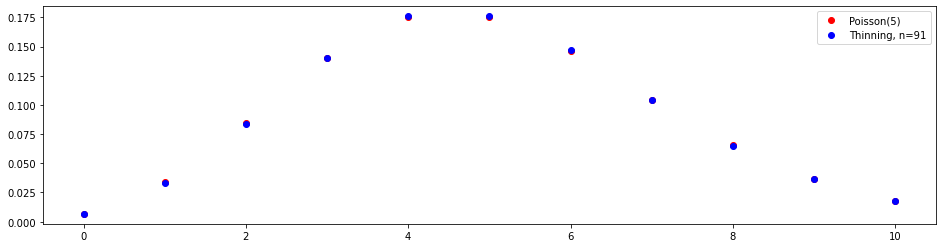

H(Geometric|Poisson(5)) is monotonically decreasing: True (should always be true)
[0.08751410503262479, 0.00035604882367229604, 9.535717536698972e-05, 4.339194332066479e-05, 2.4700388152892265e-05, 1.5922246034809145e-05, 1.1110395090503845e-05, 8.19088261290869e-06, 6.287382238193655e-06, 4.977823340190056e-06]

H(Geometric) is monotonically increasing: True (should be true only in ULC case)
H(Geometric) is monotonically decreasing: False (should be true only in ULConvex case)
[1.8759536052468004, 2.1330809031922966, 2.1397153477155473, 2.142001789676846, 2.143159592697116, 2.143859010787938, 2.1443272794309562, 2.1446627369173075, 2.1449148679207983, 2.145111289449303]

H(Geometric)_100=2.145111289449303, H(Poisson(5))=2.146692802738898
H(Geometric|Poisson(5))=4.977823340190056e-06

[0.02999771910330502, 0.0018927978243779575, 0.0009770567072661654, 0.0006584838683149116, 0.0004965744923410483, 0.00039857273493180295, 0.0003328775343196834, 0.00028577445610917076, 0.00025034934990273

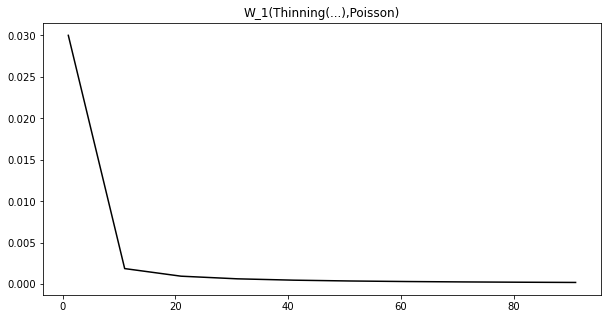

In [26]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
lmb = 5
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 100
n_step = 10
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform distribution -> Poisson distribution

0.9829072671006216
n=1, pmf sum=0.9999999999999999


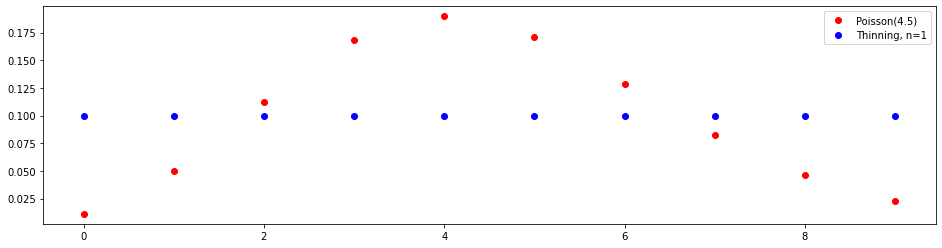

n=2, pmf sum=0.9676197052001956


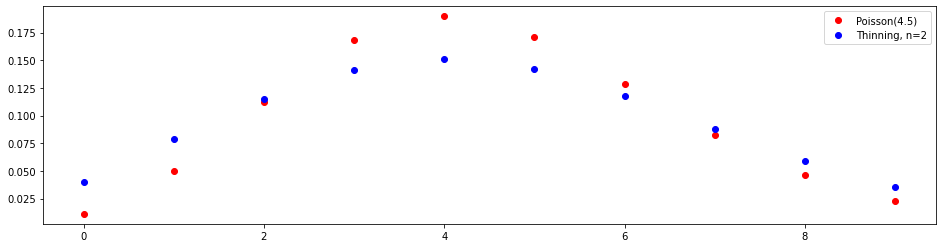

n=3, pmf sum=0.9716138015043205


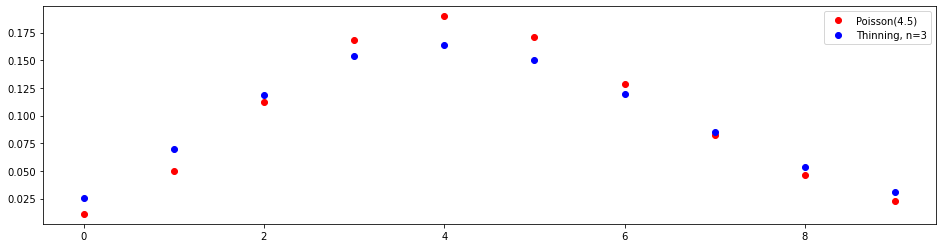

n=4, pmf sum=0.9739518291148433


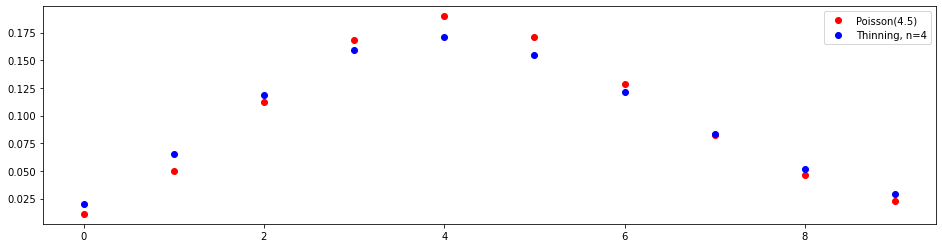

n=5, pmf sum=0.9754896432005511


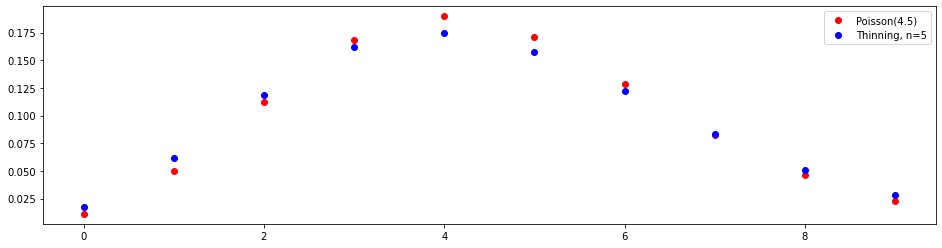

H(Binomial with a hole in the support|Poisson(4.5)) is monotonically decreasing: True (should always be true)
[0.3079556394878424, 0.044815018836803014, 0.016955972166309466, 0.008749082990952249, 0.0053140454079616175]

H(Binomial with a hole in the support) is monotonically increasing: False (should be true only in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: True (should be true only in ULConvex case)
[2.3025850929940455, 2.206287358802007, 2.1637915589443093, 2.141775708957116, 2.12868219443569]

H(Binomial with a hole in the support)_5=2.12868219443569, H(Poisson(4.5))=2.0800787768255935
H(Binomial with a hole in the support|Poisson(4.5))=0.0053140454079616175

[0.05569949284295361, 0.01951445142771996, 0.012845312062196666, 0.009540542894356623, 0.007567252203003758]

W_1(Thinning(...),Poisson) is monotonically decreasing: True
W_1(Thinning(...),Poisson) is monotonically increasing: False



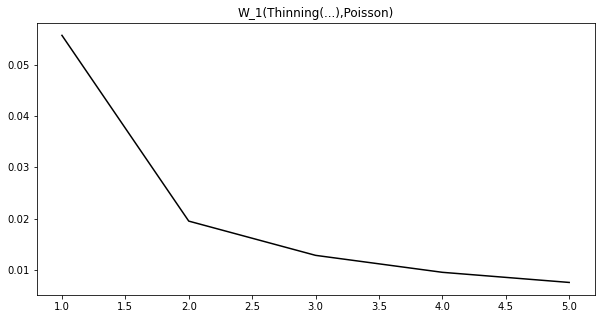

In [113]:
from decimal import Decimal

K = 9
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = K/2
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

In [ ]:
def thinning_pmf(n, k, rv):
    
    #c = (np.exp(-1/n)*(1/n)**k)/np.math.factorial(k) #with n=1, Y\sim Poisson(1). Does not make sense since we are interested in increasing n
    
    if rv == poisson_one_const:
        c = poisson.pmf(k,1)#1/(np.exp(1)*np.math.factorial(k)) #with Y_i\sim Poisson(1), i=1,...,n
        #print(c)
        #print(poisson.pmf(k,1))
        #print()
    
    if rv == poisson_onehalf_const:
        c = 0.5**k/(np.exp(0.5)*np.math.factorial(k)) #with Y_i\sim Poisson(0.5), i=1,...,n
    
    if rv == geometric_const:
        l = 0.5/n
        c = 1/(1+l)*(l/(1+l))**k #geometric
    
    if rv == binomial_const:
        c = binom.pmf(k, n, 1/n) #binomial
    
    if rv == soliton_const:
        # soliton distribution (https://en.wikipedia.org/wiki/Soliton_distribution)
        if k == 1:
            c = 1/n
        else:
            c = 1/(k*(k-1)) #k should be >0
        
    if rv == uniform_const:
        c = 1/n #uniform
    
    
    k_star = 5
    
    if rv == uniform_with_hole_const:
        if k < k_star:
            c = 1/(k_star)/2
        elif k == k_star:
            c = 0
        else:
            c = 1/(n-k_star-1)/2
                    
    if rv == poisson_with_hole_const:
        lmb = 1
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = poisson.pmf(k,lmb) + poisson.pmf(k_star,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)+np.exp(-lmb)*lmb**k_star/np.math.factorial(k_star)
        else:
            c = poisson.pmf(k,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)
    
    if rv == binomial_with_hole_const:
        p = 1/n
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = binom.pmf(k, n, p) + binom.pmf(k_star, n, p)
        else:
            c = binom.pmf(k, n, p)
        
    return c
    #print(c)
  

In [ ]:
# Init
n_min = 1
n_max = 10
n_step = 1

poisson_param = 1

n_range = range(n_min,n_max+n_step,n_step)
k_range = range(n_min,n_max)

poisson_arr = get_poisson_pmf_array(n_max, poisson_param)
    
#print(f"poisson pmf sum={sum(poisson_arr)}")

# Law of small numbers
w_range = []
for n in n_range:
    binom_arr = get_binom_pmf_array(n, 1/n)
    
    #print(f"binom pmf sum={sum(binom_arr)}, n={n}")
    
    w = wasserstein_distance(poisson_arr[:n], binom_arr)
    w_range.append(w)
    #print(w)
    
#print(np.size(poisson_arr), np.size(binom_arr))
    
display_wasserstein_distance_info(w_range, n_range, "Binomial")

# Law of thin numbers
w_range = []

entropy = []
rel_entropy = []

thinning_rv = binomial_const

for n in n_range:
    thinning_arr = get_thinning_pmf_array(n, thinning_rv)
    
    print(f"thinning pmf sum={sum(thinning_arr)}, n={n}")

    w = wasserstein_distance(poisson_arr[:n], thinning_arr)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(thinning_arr, poisson_arr[:n]))
    entropy.append(get_relative_entropy(thinning_arr))


print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(poisson_arr)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")

plot_pmf(range(0,n), thinning_arr, title=thinning_rv)
#print(np.size(poisson_arr), np.size(thinning_arr))

    
display_wasserstein_distance_info(w_range, n_range, f"Thinning({thinning_rv})")
